In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.cluster import KMeans
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedKFold, cross_val_score
from sklearn.metrics import mean_squared_log_error, make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE, mutual_info_regression, RFECV

import warnings
warnings.simplefilter(action='ignore')

# Import Data

In [2]:
df = pd.read_csv('../input/seoul-bike-rental-ai-pro-iti/train.csv')
df.columns = [i.split("(")[0].strip().title().replace(" ","_") for i in [*df.columns]]
df.head()

,Id,Date,Y,Hour,Temperature,Humidity,Wind_Speed,Visibility,Dew_Point_Temperature,Solar_Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning_Day
0,0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5760 entries, 0 to 5759
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     5760 non-null   int64  
 1   Date                   5760 non-null   object 
 2   Y                      5760 non-null   int64  
 3   Hour                   5760 non-null   int64  
 4   Temperature            5760 non-null   float64
 5   Humidity               5760 non-null   int64  
 6   Wind_Speed             5760 non-null   float64
 7   Visibility             5760 non-null   int64  
 8   Dew_Point_Temperature  5760 non-null   float64
 9   Solar_Radiation        5760 non-null   float64
 10  Rainfall               5760 non-null   float64
 11  Snowfall               5760 non-null   float64
 12  Seasons                5760 non-null   object 
 13  Holiday                5760 non-null   object 
 14  Functioning_Day        5760 non-null   object 
dtypes: f

In [4]:
data = df.copy()
data['Date'] = pd.to_datetime(data['Date'])
data['Month'] = data.Date.dt.month
data['Dayofweek'] = data.Date.dt.dayofweek
data['Year'] = data.Date.dt.year
data['workend'] = (data['Dayofweek'] == 5) | (data['Dayofweek']==6)

data.set_index('Date')

data['Functioning_Day'] = data['Functioning_Day'].map({'No': 0, 'Yes': 1})
data['Holiday'] = data['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
data['Year'] = data['Year'].map({2017:0 , 2018: 1})
data['Seasons'] = data['Seasons'].map({'Winter': 0, 'Spring': 1, 'Autumn': 2, 'Summer': 3})

num_cols = ['Temperature', 'Humidity', 'Wind_Speed', 'Dew_Point_Temperature', 'Rainfall', 'Snowfall', 
            'Solar_Radiation', 'Visibility']
cat_cols = ['Seasons', 'Holiday', 'Functioning_Day', 'Hour', 'Month', 'Dayofweek', 'Year', 'workend']

## Value Counts

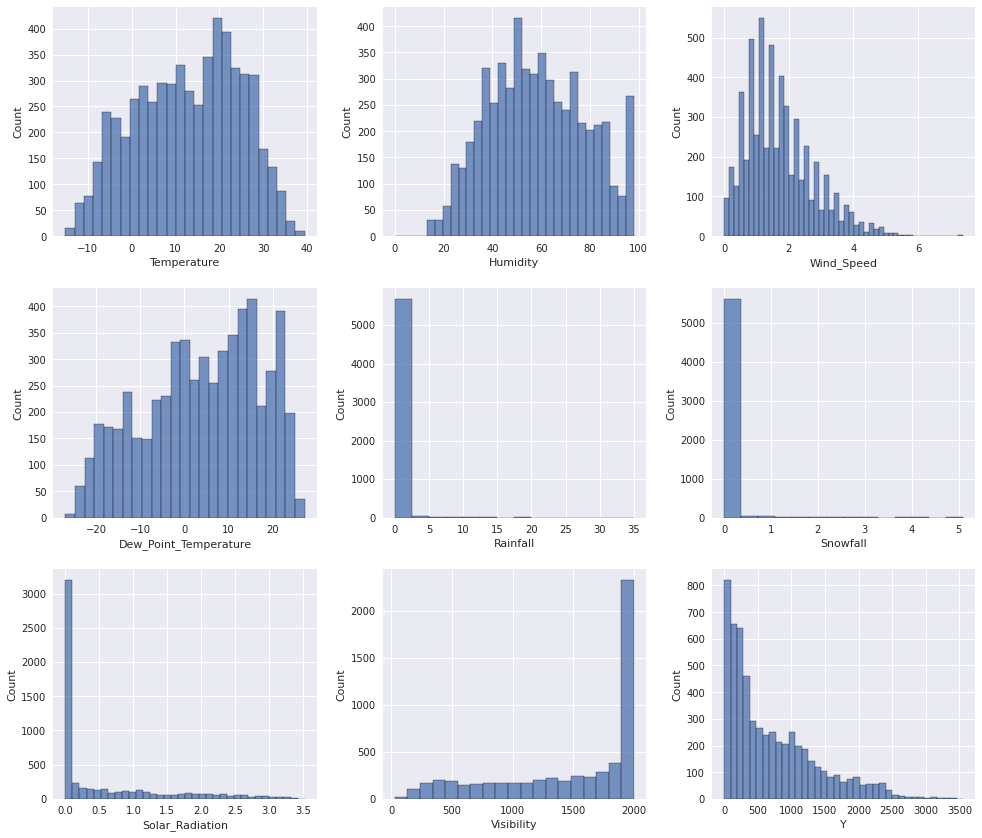

In [5]:
def plot_subplots(subplots, plot, n=3):
    m = len(subplots)
    height = (m//n + (m%n != 0)) * 4
    plt.figure(figsize=(14, height))
    for i, c in enumerate(subplots):
        plt.subplot(m//n + min(1, m%n), n, i+1)
        plot(c)
        plt.tight_layout(pad=2.0)

plot_subplots(num_cols + ['Y'], lambda c: sns.histplot(data=data, x=c))

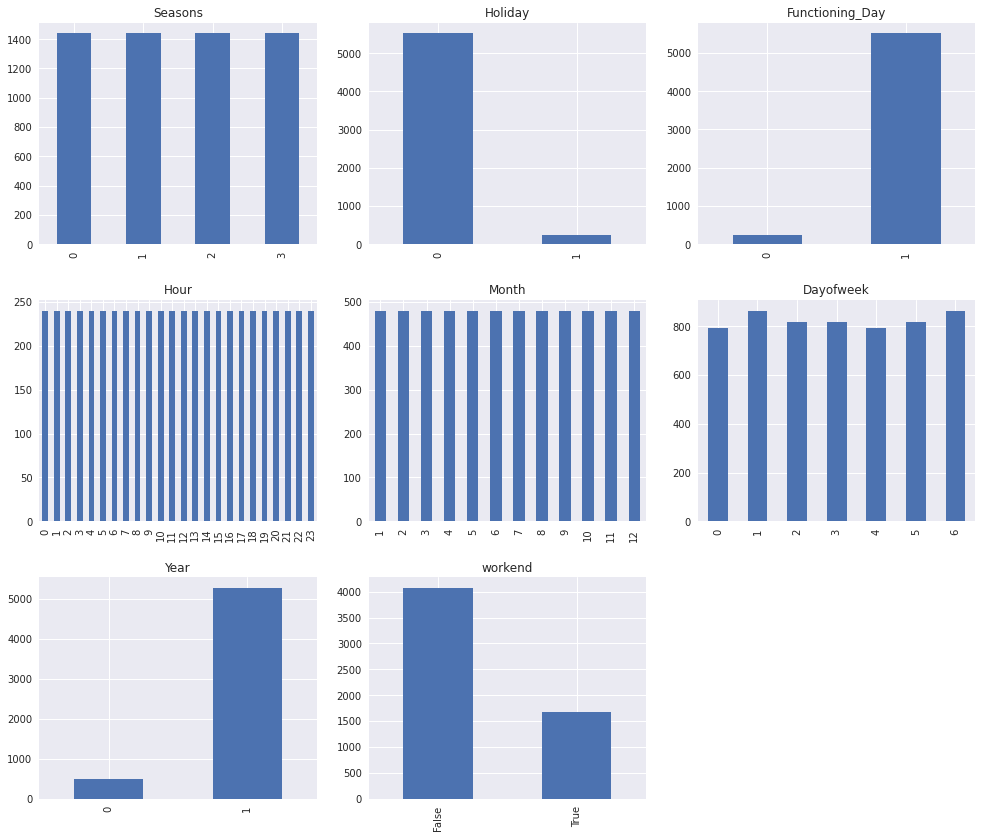

In [6]:
def plot(c):
    plt.title(c)
    data[c].value_counts().sort_index().plot.bar()
    
plot_subplots(cat_cols, lambda c: plot(c))

## Mutual Information

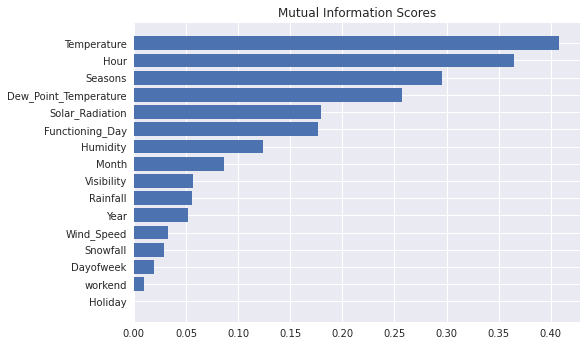

In [7]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

mi_scores = make_mi_scores(data.drop(columns=['Id', 'Date', 'Y']), data.Y, discrete_features=False)
plot_mi_scores(mi_scores)

## Numerical features

<AxesSubplot:>

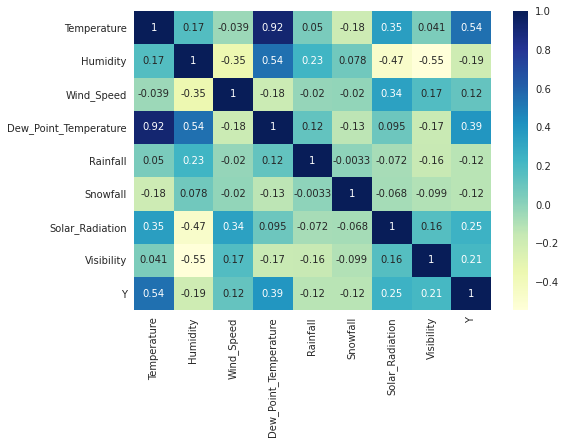

In [8]:
sns.heatmap(data[num_cols + ['Y']].corr(), annot=True, cmap="YlGnBu")

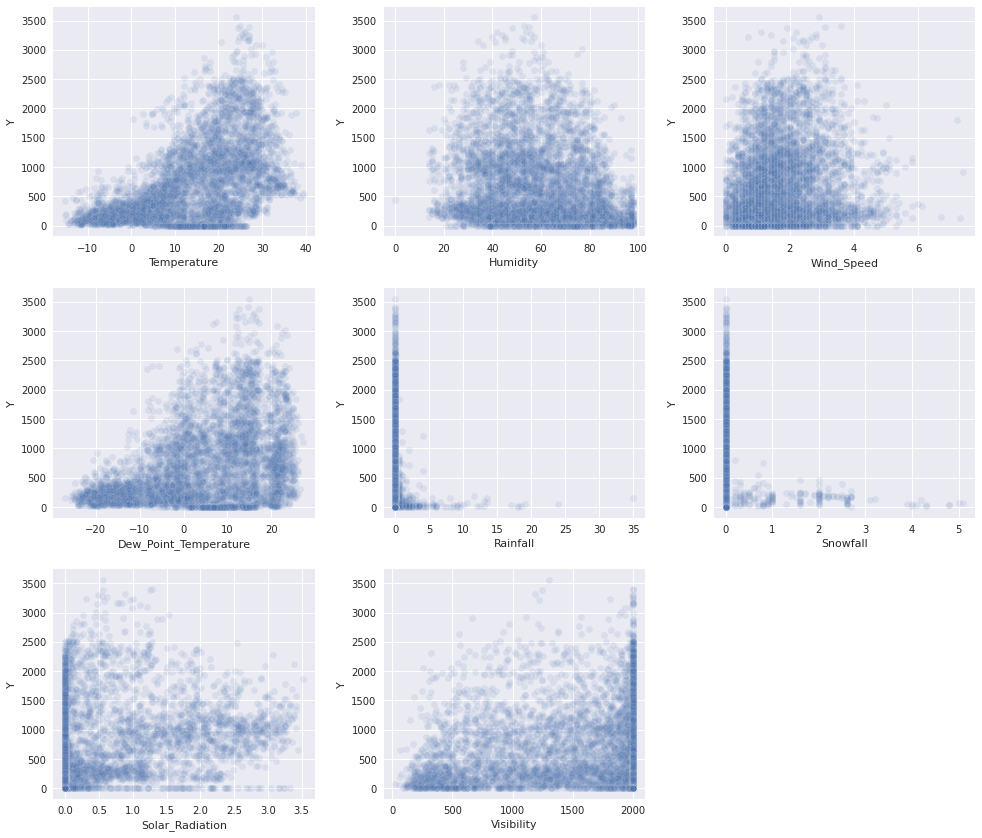

In [9]:
plot_subplots(num_cols, lambda c: sns.scatterplot(data=data, x=c, alpha=0.1, y='Y'))

### Temperature

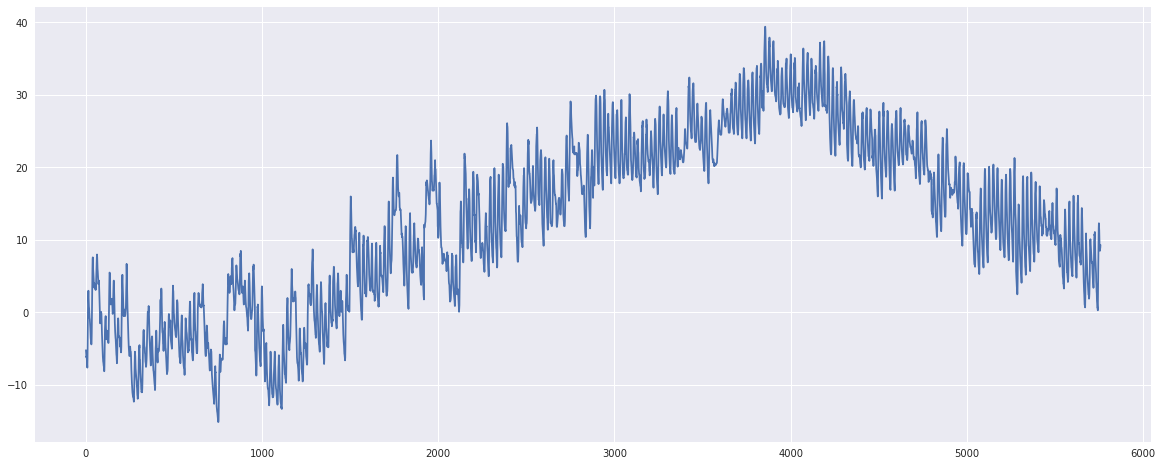

<AxesSubplot:xlabel='Month', ylabel='Temperature'>

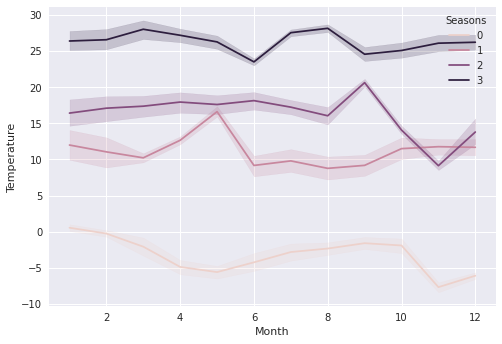

In [10]:
plt.figure(figsize=(20,8))
data['Temperature'].plot()
plt.show()
sns.lineplot('Month', 'Temperature', hue='Seasons', data=data)

<AxesSubplot:xlabel='Temperature', ylabel='Y'>

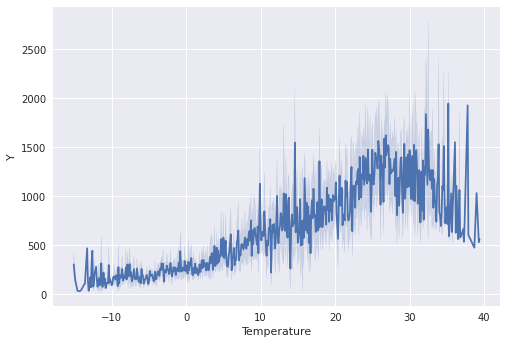

In [11]:
sns.lineplot('Temperature', 'Y', data=data)

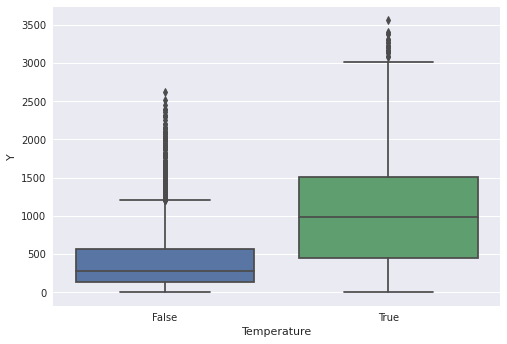

<AxesSubplot:xlabel='Temperature', ylabel='Count'>

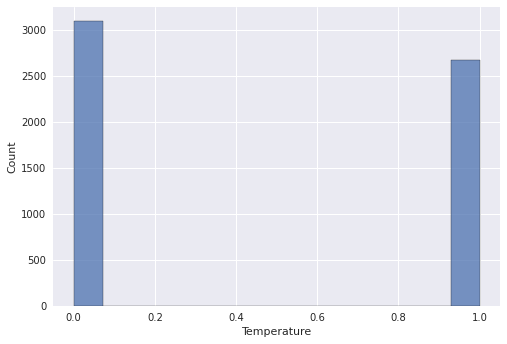

In [12]:
sns.boxplot(data['Temperature'].apply(lambda i : i >= 15 and i <=35), data['Y'])
plt.show()
sns.histplot(data['Temperature'].apply(lambda i : i >= 15 and i <=35))

### Humidity

<AxesSubplot:xlabel='Humidity', ylabel='Y'>

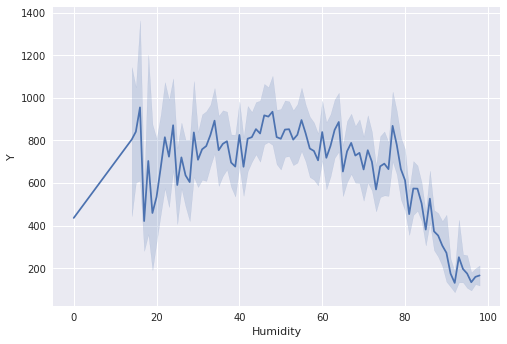

In [13]:
sns.lineplot(data.groupby(data.index)['Humidity'].mean(), data.groupby(data.index)['Y'].sum())

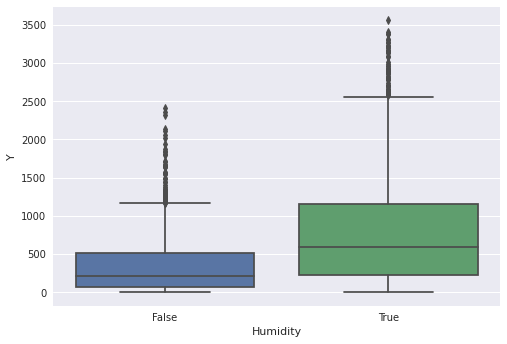

<AxesSubplot:xlabel='Humidity', ylabel='Count'>

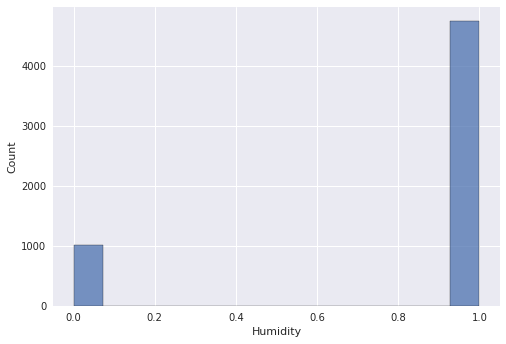

In [14]:
sns.boxplot(data['Humidity'].apply(lambda i : i >= 20 and i <=80), data['Y'])
plt.show()
sns.histplot(data['Humidity'].apply(lambda i : i >= 20 and i <=80))

### Wind Speed

<AxesSubplot:xlabel='Wind_Speed', ylabel='Y'>

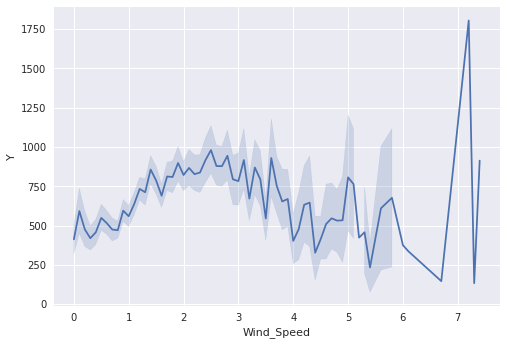

In [15]:
sns.lineplot(data.groupby(data.index)['Wind_Speed'].mean(), data.groupby(data.index)['Y'].sum())

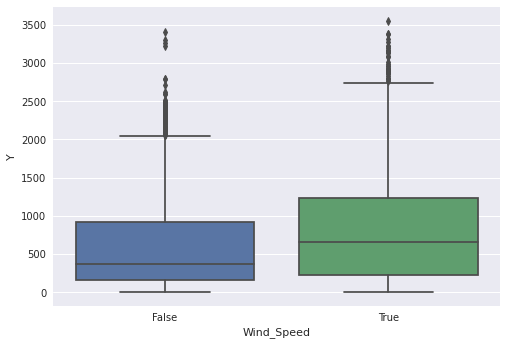

<AxesSubplot:xlabel='Wind_Speed', ylabel='Count'>

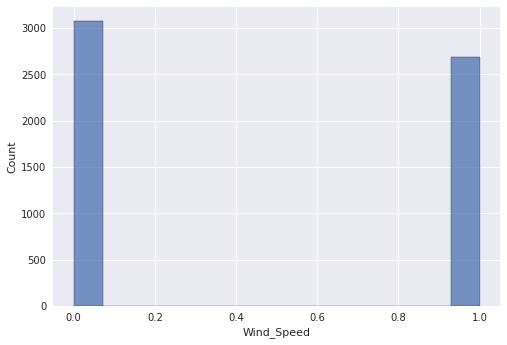

In [16]:
sns.boxplot(data['Wind_Speed'].apply(lambda i : i >= 1.5 and i <=3.5), data['Y'])
plt.show()
sns.histplot(data['Wind_Speed'].apply(lambda i : i >= 1.5 and i <=3.5))

### Rainfall

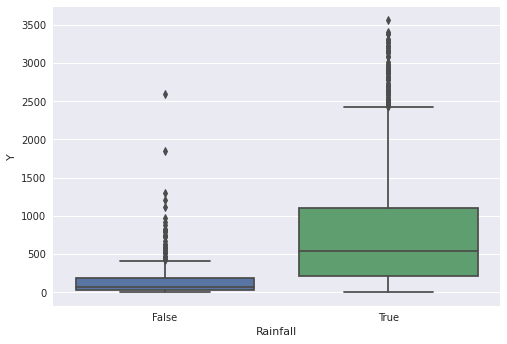

<AxesSubplot:xlabel='Rainfall', ylabel='Count'>

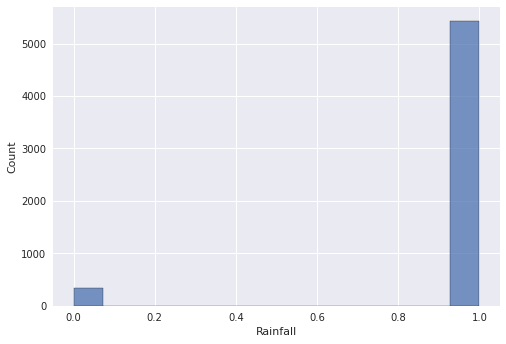

In [17]:
sns.boxplot(data['Rainfall'].apply(lambda i : i == 0), data['Y'])
plt.show()
sns.histplot(data['Rainfall'].apply(lambda i : i == 0))

### Snowfall

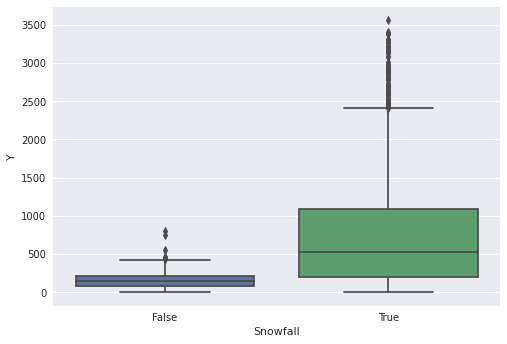

<AxesSubplot:xlabel='Snowfall', ylabel='Count'>

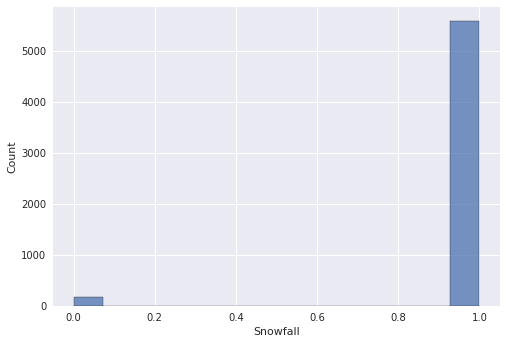

In [18]:
sns.boxplot(data['Snowfall'].apply(lambda i : i == 0), data['Y'])
plt.show()
sns.histplot(data['Snowfall'].apply(lambda i : i == 0))

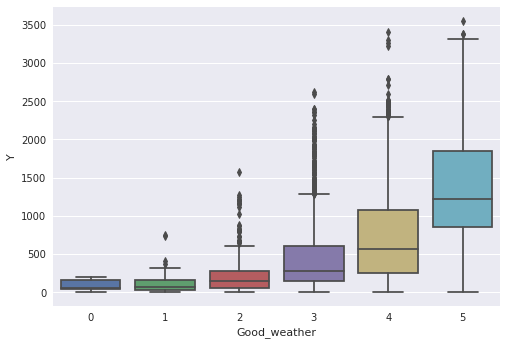

4    2133
3    1905
5    1174
2     453
1      86
0       9
Name: Good_weather, dtype: int64

In [19]:
def weather_is_good(df): 
    X = df.copy()
    X['Not_rain'] = X['Rainfall'].apply(lambda i : i == 0).astype('int')
    X['Not_snow'] = X['Snowfall'].apply(lambda i : i == 0).astype('int')
    X['Good_Temp'] = X['Temperature'].apply(lambda i : i >= 15 and i <=35).astype('int')
    X['Goop_Humid'] = X['Humidity'].apply(lambda i : i >= 20 and i <=80).astype('int')
    X['Good_Wind'] = X['Wind_Speed'].apply(lambda i : i >= 1.5 and i <=3.5).astype('int')
    return X['Not_rain'] + X['Not_snow'] + X['Good_Temp'] + X['Goop_Humid'] + X['Good_Wind']

data['Good_weather'] = weather_is_good(data)

sns.boxplot('Good_weather', 'Y', data=data)
plt.show()
data['Good_weather'].value_counts()

## Categorical features

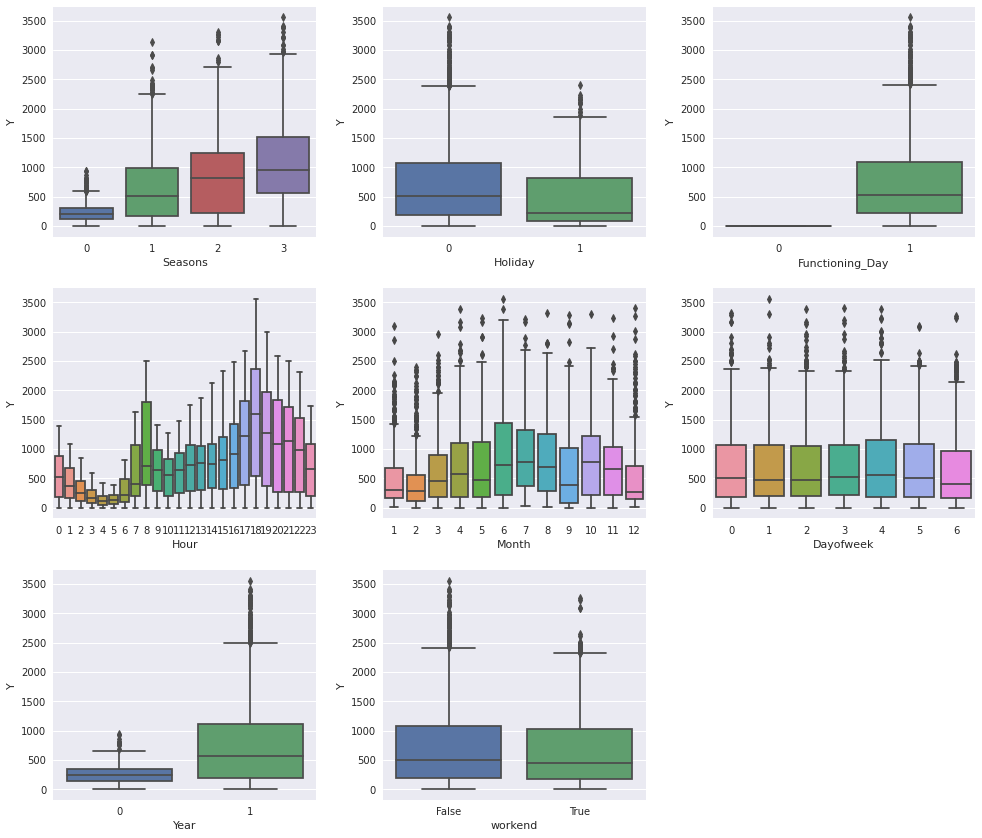

In [20]:
plot_subplots(cat_cols, lambda c : sns.boxplot(x=c, y='Y', data=data))

<AxesSubplot:xlabel='Rush_hours', ylabel='Y'>

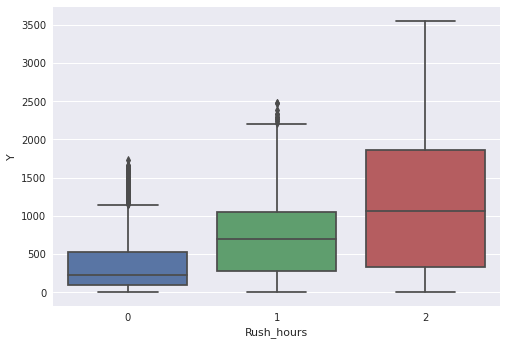

In [21]:
def rush_hours(i):
    if i in [23,0,1,2,3,4,5,6, 7]:
        return 0
    elif i in [9,10,11,12,13,14,15,16]:
        return 1
    else:
        return 2

data['Rush_hours'] = data['Hour'].apply(rush_hours)
sns.boxplot('Rush_hours', 'Y', data=data)

<AxesSubplot:xlabel='Month', ylabel='Y'>

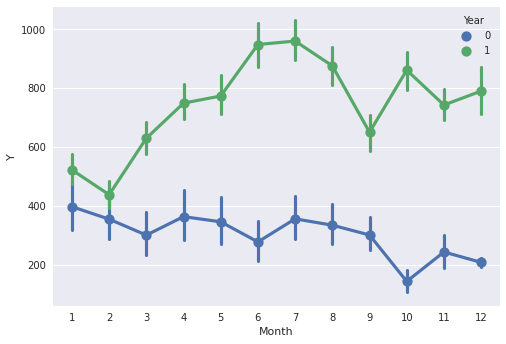

In [22]:
sns.pointplot('Month', 'Y', hue='Year', data=data)

<AxesSubplot:xlabel='Hour', ylabel='Y'>

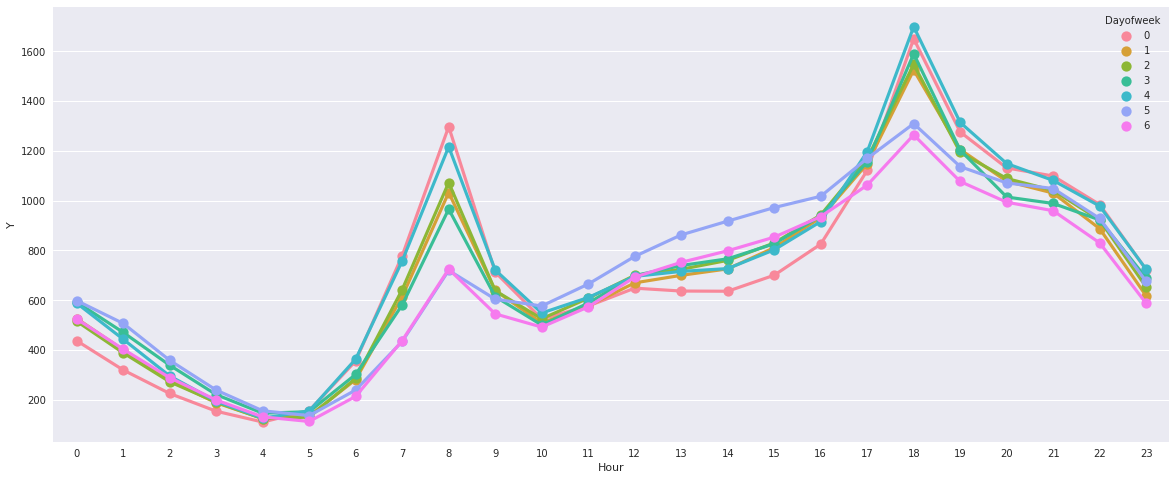

In [23]:
plt.figure(figsize=(20,8))
sns.pointplot('Hour', 'Y', hue='Dayofweek', data=data, ci=None)

## Target

<AxesSubplot:xlabel='Y'>

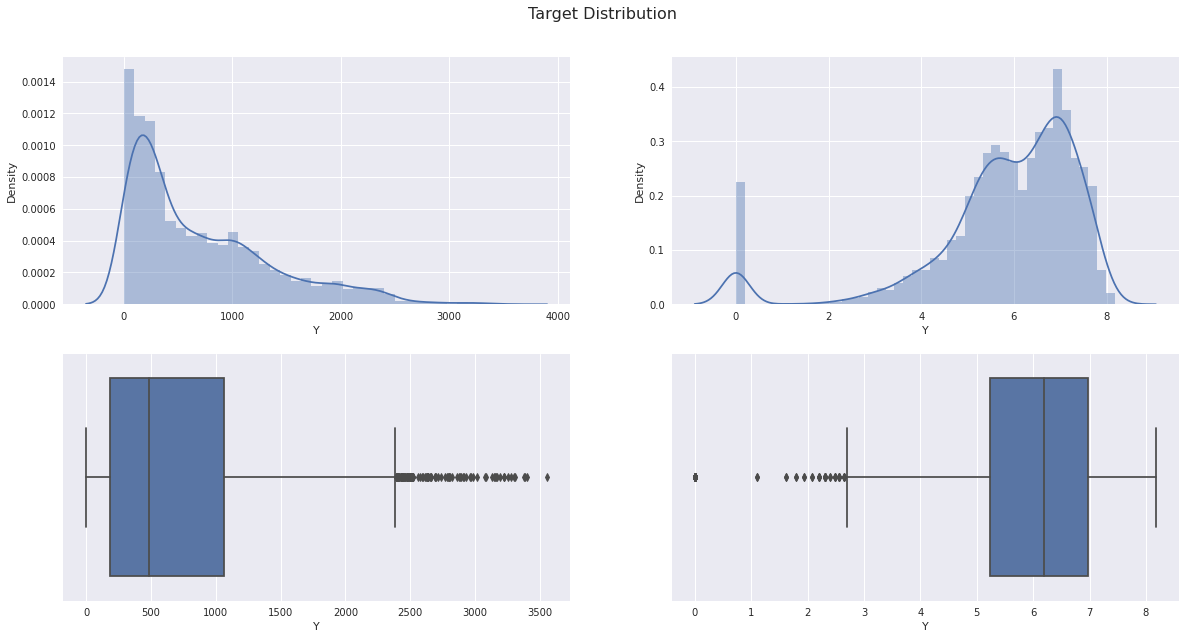

In [24]:
fig,axes = plt.subplots(2,2, figsize=(20, 10))
fig.suptitle('Target Distribution', fontsize=16, y=0.95)
sns.distplot(data["Y"],ax=axes[0][0])
sns.distplot(np.log1p(data["Y"]),ax=axes[0][1])
sns.boxplot(data['Y'], ax=axes[1][0])
sns.boxplot(np.log1p(data["Y"]), ax=axes[1][1])

# Feature engineering 

In [25]:
def encode(df):
    df['Seasons'] = df['Seasons'].map({'Winter': 0, 'Spring': 1, 'Autumn': 2, 'Summer': 3})
    df['Functioning_Day'] = df['Functioning_Day'].map({'No': 0, 'Yes': 1})
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Year'] = df['Year'].map({2017:0 , 2018: 1})
    
    return df

def add_time_features(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Month'] = df.Date.dt.month
    df['Dayofweek'] = df.Date.dt.dayofweek
    df['Year'] = df.Date.dt.year
    df['Day'] = df.Date.dt.day
#     df['Rush_hours'] = df['Hour'].apply(rush_hours)
#     df['Good_weather'] = weather_is_good(df)
#     min_temp = df.groupby('Date')['Temperature'].min()
#     df = df.merge(min_temp, how='left', suffixes=('','_min'), on='Date')
#     max_temp = df.groupby('Date')['Temperature'].max()
#     df = df.merge(max_temp, how='left', suffixes=('','_max'), on='Date')
    return df

def lag_features(df):
    for feature in ['Temperature', 'Humidity', 'Solar_Radiation', 'Rainfall', 'Wind_Speed', 'Visibility']:
        for hours in [1,2,3,-1]:
            i = str(hours)
            df[feature + '_lag_' + i] = df[feature].shift(-hours)
            df[feature + '_lag_' + i] = np.where(df[feature + '_lag_' + i].isnull(),
                                                 df[feature],
                                                 df[feature + '_lag_' + i])
    return df

def select_features(df):
    return df.drop(['Id', 'Date', 'Snowfall'], axis=1)
    
def pipeline(df):
    df = add_time_features(df)
    df = encode(df)
    df = lag_features(df)
    df = select_features(df)
    return df

In [26]:
X = df.drop('Y',axis=1)
y = df['Y']

X['Date'] = pd.to_datetime(X['Date'])
X['Day'] = X.Date.dt.day

future_days = [17,18,19,20]
X_train = X[~X.Date.dt.day.isin(future_days)]
y_train = y[~X.Date.dt.day.isin(future_days)]
X_val = X[X.Date.dt.day.isin(future_days)]
y_val = y[X.Date.dt.day.isin(future_days)]

X = X.drop(columns=['Day'])
X_train = X_train.drop(columns=['Day'])
X_val = X_val.drop(columns=['Day'])


X = pipeline(X)

X_train = pipeline(X_train)
X_val = pipeline(X_val)

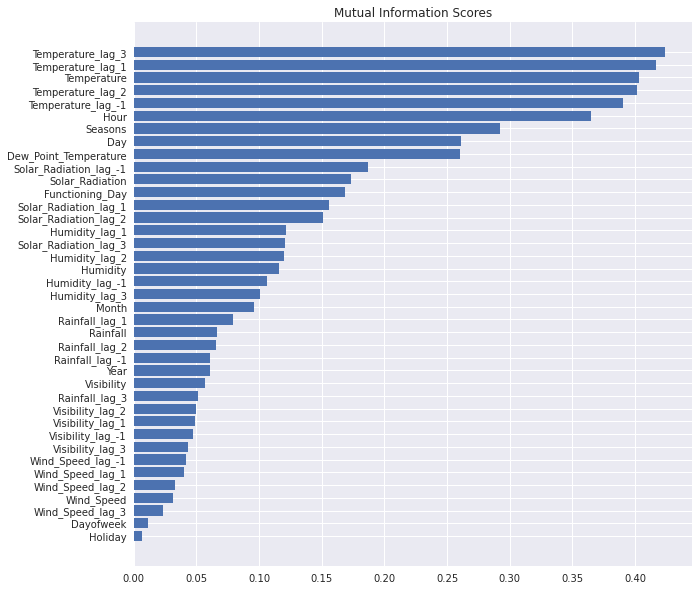

In [27]:
mi_scores = make_mi_scores(X, y, discrete_features=False)
plt.figure(figsize=(10,10))
plot_mi_scores(mi_scores)

# Model Building

In [28]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, (np.maximum(y_pred, 0))))

In [29]:
cat = CatBoostRegressor(n_estimators= 450, max_depth= 5, learning_rate= 0.1 , verbose=0)

rfe_cat = RFE(cat, n_features_to_select=27)
model = rfe_cat.fit(X_train, np.log1p(y_train))

print("Train Score : ", rmsle(y_train, np.expm1(model.predict(X_train))))
pred = np.expm1(np.maximum(model.predict(X_val), 0))
print("Validation Score : ", rmsle(y_val, pred))

Train Score :  0.2044973853401453
Validation Score :  0.3686172870409224


In [30]:
xgb = XGBRegressor(n_estimators= 200, max_depth= 5, learning_rate= 0.1)

rfe_xgb = RFE(xgb, n_features_to_select=25)
model = rfe_xgb.fit(X_train, np.log1p(y_train))

print("Train Score : ", rmsle(y_train, np.expm1(model.predict(X_train))))
pred = np.expm1(np.maximum(model.predict(X_val), 0))
print("Validation Score : ", rmsle(y_val, pred))

Train Score :  0.18711717762214639
Validation Score :  0.36274513980874606


In [31]:
model = VotingRegressor([('xgb',rfe_xgb), ('cat', rfe_cat)], weights=[0.2, 0.8])

model.fit(X_train,np.log1p(y_train))

print("Train Score : ", rmsle(y_train, np.expm1(model.predict(X_train))))
pred = np.expm1(np.maximum(model.predict(X_val), 0))
print("Validation Score : ", rmsle(y_val, pred))

Train Score :  0.197965988633822
Validation Score :  0.362271581466372


# Evaluation

In [32]:
print("MAE Score : ", mean_absolute_error(y_val, pred))
print("RMSE Score : ", np.sqrt(mean_squared_error(y_val, pred)))
print("R2 Score : ", r2_score(y_val, pred))

MAE Score :  129.95429697071555
RMSE Score :  213.7733678988718
R2 Score :  0.8950336855557992


<AxesSubplot:xlabel='Y'>

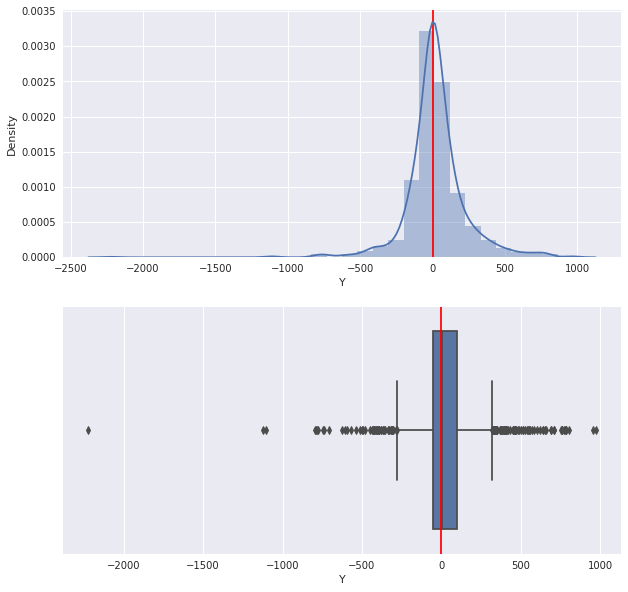

In [33]:
f, axs = plt.subplots(2,1, figsize=(10, 10))
axs[0].axvline(color='r')
axs[1].axvline(color='r')
sns.distplot(y_val - pred, bins=30, ax=axs[0])
sns.boxplot(y_val - pred, ax=axs[1])

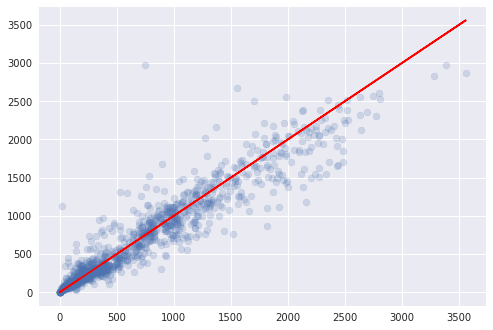

In [34]:
plt.scatter(y_val, pred, alpha=0.2)
plt.plot(y_val, y_val, color='r')
plt.show()

# Train All Data

In [35]:
model.fit(X, np.log1p(y))
print("Final Score : ", rmsle(y, np.expm1(model.predict(X))))

Final Score :  0.20915427500971803


# Submission File Generation

In [36]:
df_test = pd.read_csv('../input/seoul-bike-rental-ai-pro-iti/test.csv')
df_test.columns = [i.split("(")[0].strip().title().replace(" ","_") for i in [*df_test.columns]]

pred = model.predict(pipeline(df_test))

submission = pd.read_csv('../input/seoul-bike-rental-ai-pro-iti/sample_submission.csv')
submission['y'] = np.maximum(np.expm1(pred),0)
submission.to_csv('my_submission.csv', index=False)